# Rectified Flow
This jupyter notebook contains simple tutorial code for Rectified Flow proposed in '[Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow](https://arxiv.org/abs/2209.03003)'.

The problem here is to learn an ODE $\dot Z_t = v(Z_t, t) $ to transfer data from $\pi_0$ to $\pi_1$, where both $\pi_0$ and $\pi_1$ are unknown and empirically observed through a set of points.

The velocity field $v(z,t)$ in rectified flow can be fitted with either kernel method or deep neural networks. This tutorial illustrates the use of a neural network.

In [1]:
!nvidia-smi

Mon Nov 11 20:18:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA TITAN Xp                Off |   00000000:04:00.0 Off |                  N/A |
|122%   35C    P0             69W /  250W |       0MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Generating Distribution $\pi_0$ and $\pi_1$
We generate $\pi_0$ and $\pi_1$ as two Gaussian mixture models with different modes.

We sample 10000 data points from $\pi_0$ and $\pi_1$, respectively,
and store them in ```samples_0```, ```samples_1```.

Shape of the samples: torch.Size([10000, 2]) torch.Size([10000, 2])


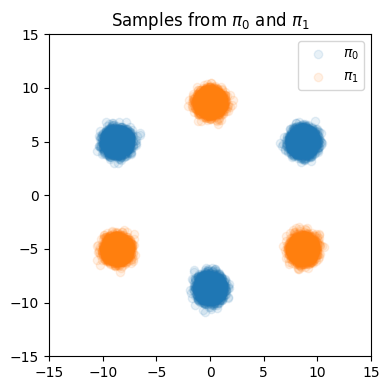

In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
import matplotlib.pyplot as plt
import torch.nn.functional as F

D = 10.
M = D+5
VAR = 0.3
DOT_SIZE = 4
COMP = 3

initial_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
initial_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., D / 2.], [-D * np.sqrt(3) / 2., D / 2.], [0.0, - D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
initial_model = MixtureSameFamily(initial_mix, initial_comp)
samples_0 = initial_model.sample([10000])

target_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
target_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., - D / 2.], [-D * np.sqrt(3) / 2., - D / 2.], [0.0, D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
target_model = MixtureSameFamily(target_mix, target_comp)
samples_1 = target_model.sample([10000])
print('Shape of the samples:', samples_0.shape, samples_1.shape)

plt.figure(figsize=(4,4))
plt.xlim(-M,M)
plt.ylim(-M,M)
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(samples_0[:, 0].cpu().numpy(), samples_0[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_0$')
plt.scatter(samples_1[:, 0].cpu().numpy(), samples_1[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_1$')
plt.legend()

plt.tight_layout()

## Define the Flow Model
Given empirical observations of $X_0\sim \pi_0$ and $X_1\sim \pi_1$,
the rectified flow induced from $(X_0,X_1)$
is an ordinary differentiable model (ODE)
on time $t\in[0,1]$,
$$
d Z_t = v^X(Z_t, t) d t,
$$
which $v$ is set in a way that ensures that $Z_1$ follows $\pi_1$ when $Z_0 \sim \pi_0$. Let $X_t = t X_1 + (1-t)X_0$ be the linear interpolation of $X_0$ and $X_1$. Then $v$ is given by
$$
v^X(z,t) = \mathbb{E}[X_1 - X_0 ~|~ X_t = z  ] =  \arg\min_{v} \int_0^1 \mathbb{E}[|| X_1-X_0 - v(X_t,t) ||^2] \mathrm{d} t,
$$
where the (conditional) expectation is w.r.t. the joint distribution of $(X_0,X_1)$.

We parameterize $v^X(z,t)$ with a 3-layer neural network.

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_num=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_num, bias=True) # input got 2 dims and time 1, thus input_dim+1
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)

    def forward(self, x_input, t):
        # inputs = torch.cat([x_input, t], dim=1)
        inputs = torch.cat([x_input], dim=1)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x

del_model = MLP()
print(del_model)

MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)


Then we define the rectfied flow class.

In [4]:
import torch.distributions as dist

def logit_normal(mu=0, sigma=1, size=(1,)):
    normal_dist = dist.Normal(mu, sigma)
    samples = normal_dist.sample(size)
    
    logit_samples = 1 / (1 + torch.exp(-samples))
    
    return logit_samples
  
    
class RectifiedFlow():
  def __init__(self, model=None, num_steps=1000):
    self.model = model.cuda()
    self.N = num_steps

  def get_train_tuple(self, z0=None, z1=None):
    t_uniform = torch.rand((z1.shape[0], 1))
    '''
    This line creates a tensor named t with the same number of rows as z1 but
    only one column. Each element in this tensor is a random number
    between 0 and 1.
    '''
    t = logit_normal(size=(z1.shape[0],))[:,None]
    assert t.shape == t_uniform.shape, f"t.shape = {t.shape} VS t_uniform.shape = {t_uniform.shape}"

    z_t =  t * z1 + (1.-t) * z0
    target = z1 - z0

    return z_t, t, target

  @torch.no_grad()
  def sample_ode(self, z0=None, N=None):
    ### NOTE: Use Euler method to sample from the learned flow
    if N is None:
      N = self.N
    dt = 1./N
    traj = [] # to store the trajectory
    z = z0.detach().clone()
    batchsize = z.shape[0]

    traj.append(z.detach().clone())
    for i in range(N):
      t = torch.ones((batchsize,1)) * i / N
      pred = self.model(z.cuda(), t.cuda()).cpu()
      z = z.detach().clone() + pred * dt

      traj.append(z.detach().clone())

    return traj

## Define the training method and other misc. code
We define the training method here. The loss function is:
$$
\min_{\theta}
\int_0^1 E_{X_0 \sim \pi_0, X_1 \sim \pi_1} \left [ {||( X_1 - X_0) - v_\theta\big (X_t,~ t\big)||}^2
\right ] \text{d}t,
~~~~~\text{with}~~~~
X_t = t X_1 + (1-t) X_0.
$$

In [5]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
  '''
  pairs:
    creation  : x_pairs = torch.stack([x_0, x_1], dim=1)
    shape     :           torch.Size([10000, 2, 2]) --> [pt, dist, x/y]

  inner_iters : number of training iterations
  '''
  loss_curve = []
  for i in range(inner_iters+1):
    optimizer.zero_grad()
    indices = torch.randperm(len(pairs))[:batchsize]
    batch = pairs[indices]
    z0 = batch[:, 0].detach().clone()
    z1 = batch[:, 1].detach().clone()
    z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

    pred = rectified_flow.model(z_t.cuda(), t.cuda())
    loss = (target.cuda() - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
    loss = loss.mean()
    loss.backward()

    optimizer.step()
    loss_curve.append(np.log(loss.item())) ## to store the loss curve

  return rectified_flow, loss_curve


Misc. code for plotting figures.

In [6]:
@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
  traj = rectified_flow.sample_ode(z0=z0, N=N)

  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)

  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj)
  num_samples = 10
  if traj_particles.shape[0] > num_samples:
    indices = torch.linspace(0, traj_particles.shape[0] - 1, num_samples).long()
    traj_particles = traj_particles[indices]

  # plt.figure(figsize=(4,4))
  # plt.xlim(-M,M)
  # plt.ylim(-M,M)
  # plt.axis('equal')
  # for i in range(30):
  #   plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1], marker='<', markersize=10, linestyle='-', linewidth=0.5)
  # plt.title('Transport Trajectory')
  # plt.tight_layout()

  fig, ax = plt.subplots(figsize=(4, 4))
  ax.set_xlim(-M, M)
  ax.set_ylim(-M, M)
  ax.set_aspect('equal')

  colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'gray']
  for i in range(30):
      color = colors[i % len(colors)]
      seq = traj_particles[:,i,:].detach().cpu().numpy()
      for seq_index in range(seq.shape[0]-1):
        dx = seq[seq_index+1, 0] - seq[seq_index, 0]
        dy = seq[seq_index+1, 1] - seq[seq_index, 1]
        ax.arrow(seq[seq_index,0],seq[seq_index,1],dx,dy, head_width=1, head_length=1, color=color)
      dx = 0
      dy = 0
      ax.arrow(seq[seq_index+1,0],seq[seq_index+1,1],dx,dy, head_width=0.1, head_length=0.1, color=color)

  ax.set_title('Transport Trajectory')
  plt.tight_layout()

## 1-Rectified Flow
We start by generating the pairs $(X_0, X_1)$ by pooling randomly sampled points from ```sample_0``` and ```sample_1```. So $(X_0,X_1)$ forms an independent coupling of $\pi_0$ and $\pi_1$.


In [7]:
x_0 = samples_0.detach().clone()[torch.randperm(len(samples_0))]
x_1 = samples_1.detach().clone()[torch.randperm(len(samples_1))]
x_pairs = torch.stack([x_0, x_1], dim=1)
print(x_pairs.shape)

torch.Size([10000, 2, 2])


We create ```rectified_flow_1``` and its corresponding ```optimizer``` and traing 1-Rectified Flow with ```train_rectified_flow``` using $(X_0, X_1)$ above.

Text(0.5, 1.0, 'Training Loss Curve')

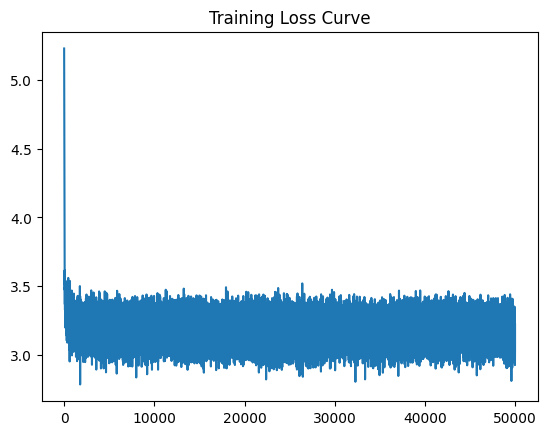

In [8]:
iterations = 50000
batchsize = 2048
input_dim = 2

rectified_flow_1 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)
optimizer = torch.optim.Adam(rectified_flow_1.model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, x_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

We run the Euler method to solve the ODE with $N=1000$ steps to generate samples from 1-Rectified Flow.

Orange dots = samples from $\pi_0$

Blue dots   = samples from $\pi_1$

Green dots  = samples from 1-Rectified Flow

1-Rectified Flow successfully learned a velocity field $v(Z_t, t)$ that can transport $\pi_0$ to $\pi_1$.

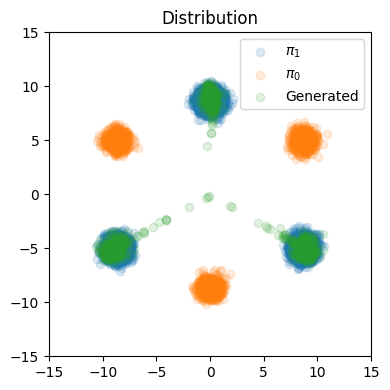

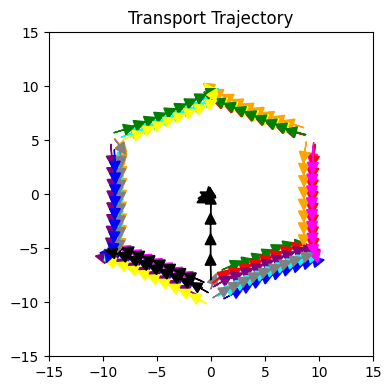

In [9]:
draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=100)

We can see that the trajectories above fit well on the trajectories of linear intepolation of data, but are "rewired" in the center when the trajectories are intersect. Hence, the resulting trajectories are either (almost)straight, or has a ">" shape.

Due to the non-straight ">"-shape paths, if we simulate the ODE with a small step $N$, we would obtain poor performance, as shown below ($N=1$).

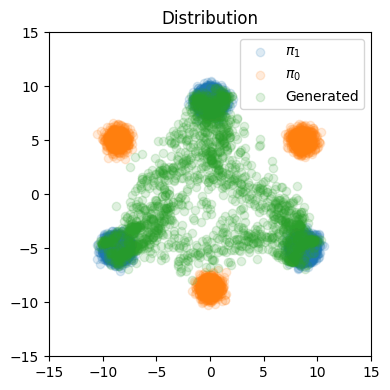

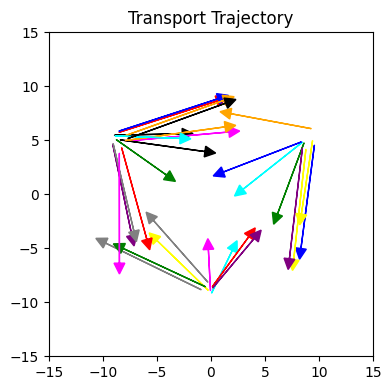

In [10]:
draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=1)

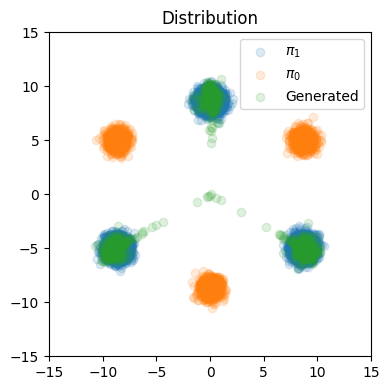

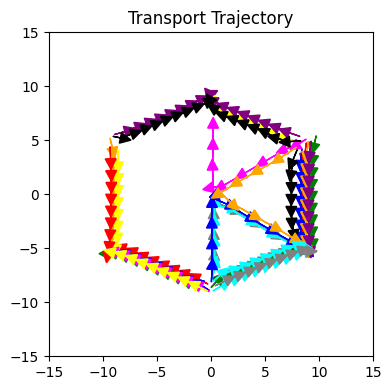

In [11]:
draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=1000)
# compare this plot with N=100 shown previously. It has much fewer errors.
# Lets repeat this with 10,000 steps

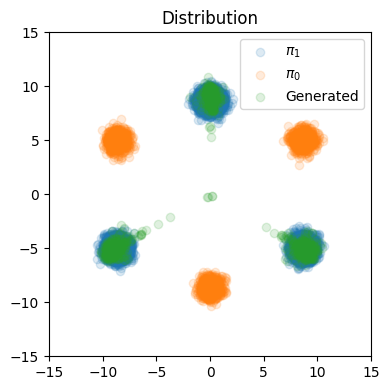

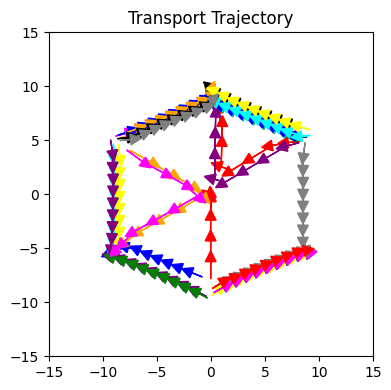

In [12]:
draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=10000)
# Not much improvemnt over the 1000 case.

## Reflow for 2-Rectified Flow
Now let's use the *reflow* procedure to get a straightened rectified flow,
denoted as 2-Rectified Flow, by repeating the same procedure on with $(X_0,X_1)$ replaced by  $(Z_0^1, Z_1^1)$, where   $(Z_0^1, Z_1^1)$ is the coupling simulated from 1-Rectified Flow.  
Specifically, we randomly sample 10000 $Z_0^1$  and generate their corresponding  $Z_1^1$ by simulating 1-Rectified Flow.

In [13]:
z10 = samples_0.detach().clone()
traj = rectified_flow_1.sample_ode(z0=z10.detach().clone(), N=1000)
z11 = traj[-1].detach().clone()
z_pairs = torch.stack([z10, z11], dim=1)
print(z_pairs.shape)

torch.Size([10000, 2, 2])


The coupling $(Z_0^1, Z_1^1)$ is now deterministic. The loss function is:
$$
\min_{\theta}
\int_0^1 E_{(Z_0, Z_1) \sim (Z_0^1, Z_1^1)} \left [ {||( Z_1 - Z_0) - v_\theta\big (Z_t,~ t\big)||}^2
\right ] \text{d}t,
~~~~~\text{with}~~~~
Z_t = t Z_1 + (1-t) Z_0.
$$

We create ```rectified_flow_2``` and its corresponding ```optimizer``` and traing 2-Rectified Flow with ```train_rectified_flow```.

We use the model pretrained in 1-Rectified Flow to accelerate training.

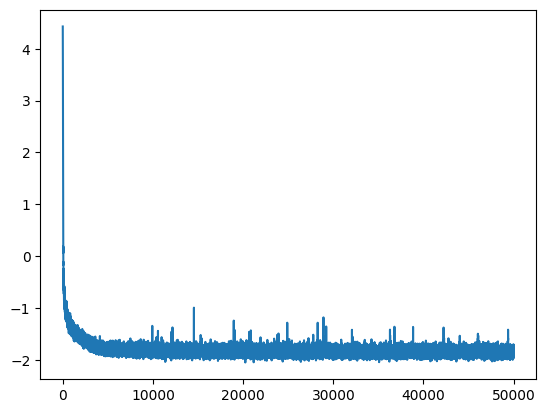

In [14]:
reflow_iterations = 50000

rectified_flow_2 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)
import copy
rectified_flow_2.net = copy.deepcopy(rectified_flow_1) # we fine-tune the model from 1-Rectified Flow for faster training.
optimizer = torch.optim.Adam(rectified_flow_2.model.parameters(), lr=5e-3)

rectified_flow_2, loss_curve = train_rectified_flow(rectified_flow_2, optimizer, z_pairs, batchsize, reflow_iterations)
plt.plot(np.linspace(0, reflow_iterations, reflow_iterations+1), loss_curve[:(reflow_iterations+1)])

We run the Euler method to solve the ODE with $N=100$ steps to generate samples from 2-Rectified Flow.

2-Rectified Flow can also successfully learn a velocity field $v(Z_t, t)$ that can transport $\pi_0$ to $\pi_1$.

The key point, however, is that the transport trajectory is now **straightened** and hence we would not lose much accuracy even if we solve the ODE with one Euler step ($N=1$).

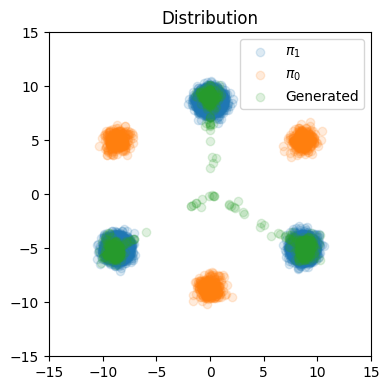

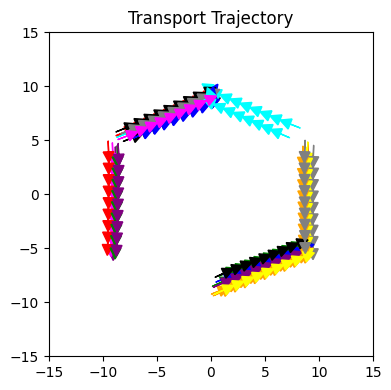

In [15]:
draw_plot(rectified_flow_2, z0=initial_model.sample([1000]), z1=samples_1.detach().clone())

So below is the result when we solve the ODE with $N=1$ Euler step to generate samples from 2-Rectified Flow.

With the **straightened** trajectory, we get almost perfect results with only  one-step generation! Thanks to the power of **Reflow** !

More croncretely, the output of the model is now $Z_1 = Z_0 + v(Z_0, 0)$.

Effectively, we have trained a one-step model, by using ODE as an intermediate step.

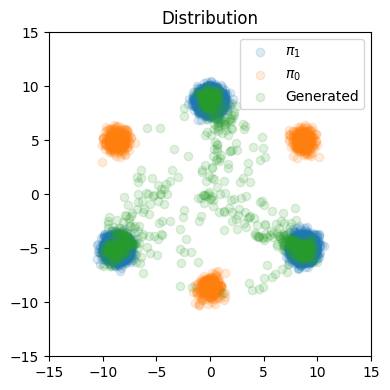

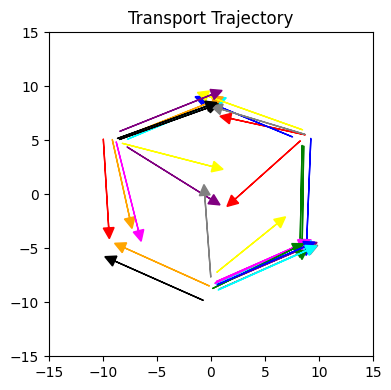

In [16]:
draw_plot(rectified_flow_2, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=1)

# Notes 

### Exponential Moving Average: Decay

Here we have not used EMA, but in relaity we will use it. So lets explore different facets of EMA.

The plot of the decay function with an initial decay of 0.9, using the formula:

$$
\text{decay} = \min\left(\text{decay}, \frac{1 + \text{num\_updates}}{10 + \text{num\_updates}}\right)
$$


where the EMA update rule is `s = d.s + (1-d).p`

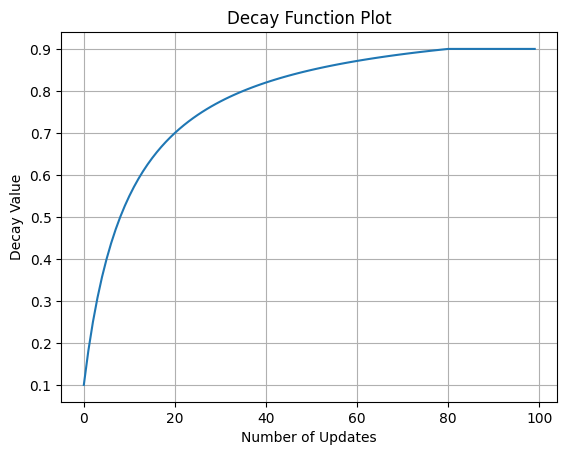

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(100), [min(0.9, (1 + n) / (10 + n)) for n in range(100)])
plt.xlabel('Number of Updates')
plt.ylabel('Decay Value')
plt.title('Decay Function Plot')
plt.grid(True)
plt.show()


### Implementing Logit-Normal Distribution

The SD3 paper endorsed the Rectify Flow paper with a suggestion that model needs to work most on in the middle timestep. So instead of uniform sampling suggested Logit-Normal distribution.

Lets implement that. Taken from https://arxiv.org/pdf/2410.10356

Text(0, 0.5, 'Logit-Normal(t)')

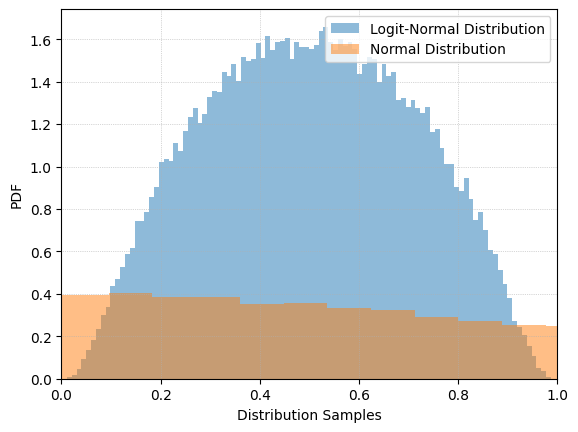

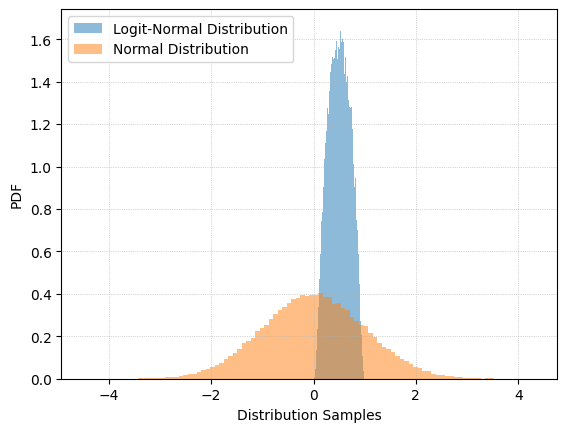

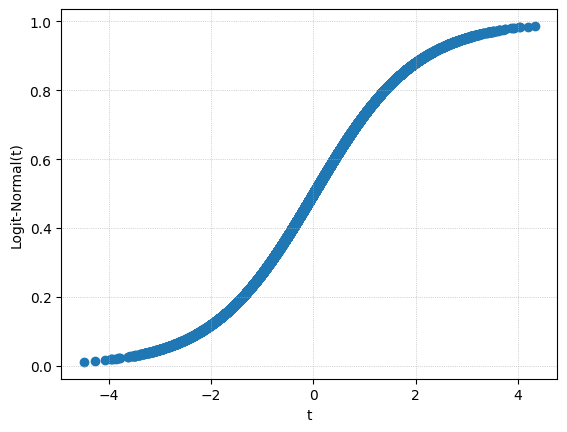

In [18]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt

def logit_normal(mu=0, sigma=1, size=(1,)):
    normal_dist = dist.Normal(mu, sigma)
    samples = normal_dist.sample(size)
    
    logit_samples = 1 / (1 + torch.exp(-samples))
    
    return logit_samples, samples

logit_samples, samples = logit_normal(size=(90000,))

logit_samples, samples = logit_samples.numpy(), samples.numpy()

plt.figure()
plt.hist(logit_samples, bins=100, density=True, alpha=0.5, label='Logit-Normal Distribution')
plt.hist(samples, bins=100, density=True, alpha=0.5, label='Normal Distribution')
plt.xlabel('Distribution Samples')
plt.xlim([0,1])
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend()
plt.ylabel('PDF')

plt.figure()
plt.hist(logit_samples, bins=100, density=True, alpha=0.5, label='Logit-Normal Distribution')
plt.hist(samples, bins=100, density=True, alpha=0.5, label='Normal Distribution')
plt.xlabel('Distribution Samples')
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend()
plt.ylabel('PDF')

plt.figure()
plt.scatter(samples, logit_samples)
plt.xlabel('t')
plt.grid(True, linestyle=':', linewidth=0.5)
plt.ylabel('Logit-Normal(t)')

# Rough Work

In [19]:
import torch

def append_dims(t, ndims):
    shape = t.shape
    return t.reshape(*shape, *((1,) * ndims))

t = torch.randn(2, 3)
new_t = append_dims(t, 2)

print(t.shape)      # Output: torch.Size([2, 3])
print(new_t.shape)  # Output: torch.Size([2, 3, 1, 1])


torch.Size([2, 3])
torch.Size([2, 3, 1, 1])


In [20]:
t = torch.rand((10, 1))
print(t.shape)
t, _ = logit_normal(size=(10,))
print(t[:,None].shape)

torch.Size([10, 1])
torch.Size([10, 1])
